In [57]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,OneHotEncoder,OrdinalEncoder
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import StackingRegressor



from xgboost import XGBRegressor


In [58]:
train_df = pd.read_csv('train.csv',index_col=0)
test_df = pd.read_csv('test.csv',index_col=0)


X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

X_test=test_df

X_train.describe()

print(X_train.isnull().sum())

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

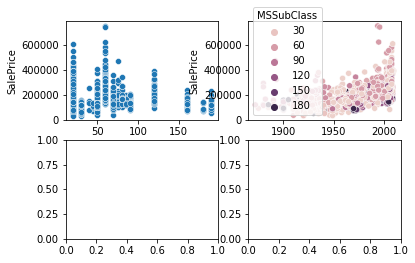

In [91]:
fig,axes=plt.subplots(2,2)
sns.scatterplot(x=X_train['MSSubClass'],y=y_train,ax=axes[0,0])
sns.scatterplot(x=X_train['YearBuilt'],y=y_train,hue=X_train['MSSubClass'],ax=axes[0,1])


columns_to_plot = ['Condition1', 'Neighborhood', 'OverallCond', 'GarageCars']
melted_data = pd.melt(X_train[columns_to_plot])

sns.barplot(x='variable', y='value', data=melted_data, ax=axes[1, 1])

axes[1, 1].set_xticklabels(columns_to_plot)
plt.tight_layout()
plt.show()

In [61]:
numerical_cols=X_train.select_dtypes(exclude=['object'])
categorical_cols=X_train.select_dtypes(include=['object'])
cols_with_missing_values=[cols for cols in X_train.columns if X_train[cols].isnull().sum().any()]
print(cols_with_missing_values)


['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [62]:
ordinal_encoder=OrdinalEncoder()
hot_encoder=OneHotEncoder(handle_unknown='ignore')

numerical_imputer=SimpleImputer(strategy='mean')
categorical_imputer=SimpleImputer(strategy='most_frequent')

standard_scaler=StandardScaler()
min_max_scaler=MinMaxScaler()
power_transformer=PowerTransformer()


In [63]:
my_pipeline1=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('standard_scaler',standard_scaler)  
])

In [64]:
my_pipeline2=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('min_max_scaler',min_max_scaler)
])

In [65]:
my_pipeline3=Pipeline(steps=[
    ('numerical_imputer',numerical_imputer),
    ('power_transformer',power_transformer)   
])

In [66]:
my_pipeline4=Pipeline(steps=[
    ('categorical_imputer',categorical_imputer),
    ('ordinal_encoder',ordinal_encoder)
    ])

In [67]:
my_pipeline5=Pipeline(steps=[
    ('categorical_imputer',categorical_imputer),
    ('one_hot_encoder',hot_encoder)
])

In [68]:
class CustomEncoder(BaseEstimator,TransformerMixin):
    
    def __init__(self,threshold=10):
        self.threshold=threshold
        self.one_hot_cols=[]
        self.ordinal_cols=[]
        
    def fit(self,X, y=None):
        for col in X.columns:
            if X[col].nunique()<self.threshold:
                self.one_hot_cols.append(col)
            else:
                self.ordinal_cols.append(col)
        return self
    
    def transform(self,X,y=None):
        one_hot_encoder=OneHotEncoder(handle_unknown='ignore')
        ordinal_encoder=OneHotEncoder()
        
        one_hot_encoded=one_hot_encoder.fit_transform(X[self.one_hot_cols])
        ordinal_encoded=ordinal_encoder.fit_transform(X[self.ordinal_cols])
        
        one_hot_df=pd.DataFrame(one_hot_encoded.toarray(),columns=self.one_hot_cols)
        ordinal_df=pd.DataFrame(ordinal_encoded,columns=self.ordinal_cols)
        
        return pd.concat([one_hot_df,ordinal_df],axis=1)
    
    
my_pipeline6=Pipeline(steps=[
    ('categorical_imputer',categorical_imputer),
    ('custom_encoder',CustomEncoder(threshold=10))
])
    

In [69]:
def fit_pca(X_train,X_test,n_components=15):
    pca=PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_reduced=pca.transform(X_train)
    X_test_reduced=pca.transform(X_test)
    
    return X_train_reduced,X_test_reduced

In [70]:
def rand_forest_mod(X_train,y_train):
    model=RandomForestRegressor(random_state=0)
    param_grid={
        'n_estimator':[i for i in range(50,300,50)],
        'criterion':['gini','entropy'],
        'bootstrap':[True,False],
        'max_features':['auto','log2','sqrt','None']
        
    }
    
    search_cv=GridSearchCV(model,param_grid,cv=5)
    search_cv.fit(X_train,y_train)
    best_params = search_cv.best_params_
    best_model = search_cv.best_estimator_
    best_score=search_cv.best_score_
    
    return best_model,best_params,best_score
    

In [71]:
def xgb_reg(X_train,y_train):
    model=XGBRegressor()
    
    param_grid = {
    'n_estimators': [i for i in range(100,1000,80)],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.05,0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_param=grid_search.best_params_
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    
    return best_estimator,best_param,best_score


In [72]:
def decision_tree(X_train,y_train):
    model=DecisionTreeRegressor(random_state=0)
    param_grid={
        'criterion':['gini','entropy'],
        'max_features':['auto','log2','sqrt','None']
    }
    grid_search=GridSearchCV(model,param_grid,cv=5)
    best_param=grid_search.best_params_
    best_estimator=grid_search.best_estimator_
    best_score=grid_search.best_score_
    
    return best_param,best_estimator,best_score
    

In [73]:
def adaboost(X_train,y_train):
    model=AdaBoostRegressor(random_state=0)
    param_grid={
        'learning_rate':[0.01,0.05,0.1,0.5,0.8,1.0],
        'loss':['linear','square','exponential'],
        'base_estimator':['DecisionTreeRegressor','svr','LinearRegression'],
        'n_estimator':[i for i in range(50,300,50)]
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [74]:
def catboost(X_train,y_train):
    model=CatBoostRegressor()
    
    param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'n_estimators': [100, 200, 300]
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_params=grid_search.best_params_
    best_estimator=grid_search.best_estimator_
    
    return best_score,best_params,best_estimator

In [75]:
def ridge(X_train,y_train):
    model=Ridge()
    param_grid={
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [76]:
def lasso(X_train,y_train):
    model=Lasso()
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
        }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [77]:
def svm_svr(X_train,y_train):
    model=SVR()
    param_grid={
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'C': [0.01, 0.1, 1, 10, 100],
         'degree': [2, 3, 4],
         'gamma': [0.1, 1, 'scale', 'auto'],
         'coef0': [0.0, 0.1, 1.0],
         'epsilon': [0.01, 0.1, 0.2, 0.5]

    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [78]:

def build_model(X_train,y_train,hidden_layer_sizes=(32, 32), activation='relu'):
    model = keras.models.Sequential([
        keras.layers.Dense(hidden_layer_sizes[0], activation=activation, input_shape=(X_train.shape[1],)),
        keras.layers.Dense(hidden_layer_sizes[1], activation=activation),
        keras.layers.Dense(1, activation='linear')  
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    param_grid = {
   'hidden_layer_sizes': [(32, 32), (64, 64), (128, 128)],
   'activation': ['relu', 'tanh']
    }
    
    nn_regressor = StackingRegressor(build_fn=build_model, verbose=0)
    grid_search = GridSearchCV(estimator=nn_regressor, param_grid=param_grid, cv=3)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_score=grid_search.best_score_

    return best_model,best_params,best_score

